# Imports

In [1]:
import os; os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
# import library
%run lib.ipynb

from scipy import stats
from scipy.stats import poisson

2021-07-12 22:20:37.851552: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-07-12 22:20:37.851576: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Plot poisson

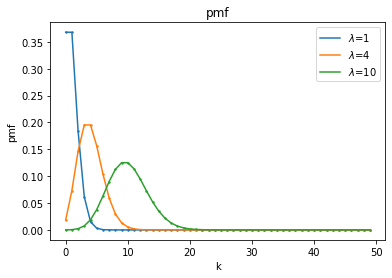

In [2]:
from collections.abc import Iterable

def plot_poisson(mu, M):

    plt.title(f'pmf')
    plt.xlabel('k')
    plt.ylabel('pmf')
    
    k = np.array(range(M))
    
    if isinstance(mu, Iterable):
        
        for mu_i in mu:

            # pmf
            pmf_i = poisson.pmf(k=range(M), mu=mu_i)
            
            # plot
            x = k
            y = pmf_i
            _ = plt.scatter(x, y, zorder=1, s=2)
            _ = plt.plot(x, y, zorder=2, label=f'$\lambda$={mu_i}')
    else: # single
        
        # pmf
        pmf = poisson.pmf(k=range(M), mu=mu)
        
        # plot
        x = k
        y = pmf
        _ = plt.scatter(x, y, zorder=1, s=2)
        _ = plt.plot(x, y, zorder=2, label=f'$\lambda$={mu}')
    
    plt.legend()

# plot_poisson(mu=1, M=20)
plot_poisson(mu=[1, 4, 10], M=50)

# Generate data (poisson)

In [3]:
def sample_poisson(lam, size):
    return poisson.rvs(mu=lam, loc=0, size=size)
#     return np.random.poisson(lam=lam, size=size)

def next_lambda(min_lambda=1, max_lambda=10):
    return np.random.uniform(low=min_lambda, high=max_lambda, size=1)[0]

# generate data (poisson)
def generate_data_poisson(N, M, density=True):
    
    # generate histogram and corresponding lambda values
    raw, H, lambdas = generate_data(N=N, M=M, nextConfig=next_lambda, sample=sample_poisson, density=density)

    # split train/test
    # (use train_test_split so the shape of the train/test data will be the same)
    H_train, H_test, y_train, y_test = train_test_split(H, lambdas, test_size=0.25)
    
    return H_train, y_train, H_test, y_test

## Plot sample data

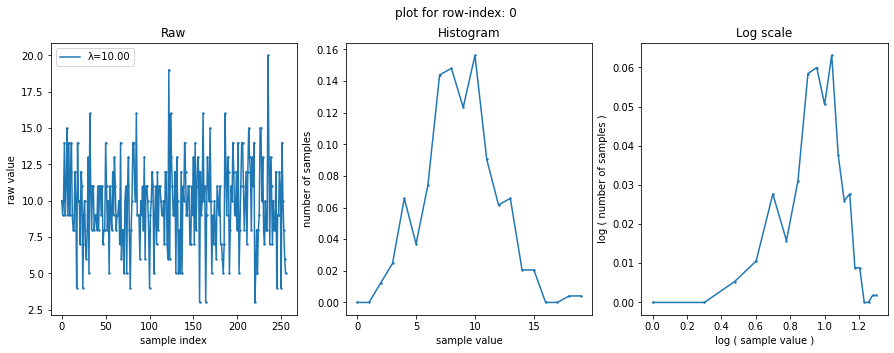

In [4]:
# plot helper function
def plot_raw_histogram_and_logscale(raw, H, lambdas):
    """
    plot data:
        - histogram
        - log scale
    """

    # two plots side by side
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
    
    # select random row index
    ROW_INDEX_TO_PLOT = random.randint(0, H.shape[0] - 1)
    lam = lambdas[ROW_INDEX_TO_PLOT]
    fig.suptitle(f'plot for row-index: {ROW_INDEX_TO_PLOT}')

    # plot raw
    y = raw[ROW_INDEX_TO_PLOT,:]
    x = np.array(range(len(y)))

    ax1.set_title(f'Raw')
    ax1.set_xlabel('sample index')
    ax1.set_ylabel('raw value')
    ax1.scatter(x, y, zorder=1, s=2)
    ax1.plot(x, y, zorder=2, label=f'λ={lam:.2f}')
    ax1.legend()
    
    # plot histogram
    y = H[ROW_INDEX_TO_PLOT,:]
    x = np.array(range(len(y)))
    
    ax2.set_title(f'Histogram')
    ax2.set_xlabel('sample value')
    ax2.set_ylabel('number of samples')
    ax2.scatter(x, y, zorder=1, s=2)
    ax2.plot(x, y, zorder=2)
    
    # plot log scale
    # (shift H values by one so as not to take log of zero)
    x = np.log10(x + 1)
    y = np.log10(y + 1)
    
    ax3.set_title('Log scale')
    ax3.set_xlabel('log ( sample value )')
    ax3.set_ylabel('log ( number of samples )')
    ax3.scatter(x, y, zorder=1, s=2)
    ax3.plot(x, y, zorder=2)

# generate data
raw, H, lambdas = generate_data(N=1, M=256, nextConfig=10.0, sample=sample_poisson, density=True)

# plot single input row
plot_raw_histogram_and_logscale(raw, H, lambdas)

# Experiments
Learn Poisson in three different settings:

Use exact values.  
Use Log.  
Use P values, defined from the poisson thingy.  
P(k) = Log(MEASURED(k) * k!)

In [5]:
N = 10000

In [6]:
# shared function used in experiments
def Poisson_Experiment(X_train, y_train, X_test, y_test):

    start_time = time.time()
    dnn_model, history, y_pred, sqrt_mse = dnn_trial(X_train, y_train, X_test, y_test)
    train_time = round(time.time() - start_time)

    # debug print
    loss = np.min(history['loss'])
    val_loss = np.min(history['val_loss'])
    print(f'sqrt-mse: {sqrt_mse:.4f}', end=', ')
    #print(f'loss: {loss:.4f}', end=', ')
    #print(f'val_loss: {val_loss:.4f}', end=', ')
    print(f'train-time: {round(train_time)} sec.')

    trial = {
        'model': dnn_model,
        'history': history,
        'y-test': y_test,
        'y-pred': y_pred,
        'sqrt-mse': sqrt_mse,
        'train-time': train_time
    }

    return trial

## Experiment 1 - log vs. exact training

In [7]:
def experiment_1():
    
    trials = []
    
    d = {
        'M': [], 
        'm': [],
        'log-scale': [],
        'sqrt-mse': [],
        'train-time (sec.)': []
    }

    for M in [64, 128, 256, 512, 1024, 2048, 4096, 8192]:
        
        print()
        print(f'generating dataset (M={M}) ... ', end='')
        X_train, y_train, X_test, y_test = generate_data_poisson(N=N, M=M)
        print(f'train input.shape: {X_train.shape}')

        m = X_train.shape[1]
        
        for apply_log_scale in [True, False]:

            if apply_log_scale:
                X_train = log_scale(X_train)
                X_test = log_scale(X_test)
                print(f'training (log-scale) ... ', end='')
            else:
                print(f'training (exact-values) ... ', end='')
            
            trial = Poisson_Experiment(X_train, y_train, X_test, y_test)
            
            trials.append(trial)
            
            sqrt_mse = trial['sqrt-mse']
            train_time = trial['train-time']
            
            d['M'].append(M)
            d['m'].append(m)
            d['log-scale'].append(apply_log_scale)
            d['sqrt-mse'].append(round(sqrt_mse, 4))
            d['train-time (sec.)'].append(f'{train_time}')
    
    df = pd.DataFrame(data=d)
    return trials, df

exp_1_trials, exp_1_df = experiment_1()


generating dataset (M=64) ... train input.shape: (7500, 25)
training (log-scale) ... 

2021-07-12 22:20:41.341006: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-07-12 22:20:41.341024: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-07-12 22:20:41.341041: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ubuntu-ww): /proc/driver/nvidia/version does not exist
2021-07-12 22:20:41.341182: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-07-12 22:20:41.540051: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Opti

sqrt-mse: 0.3643, train-time: 36 sec.
training (exact-values) ... sqrt-mse: 0.3158, train-time: 21 sec.

generating dataset (M=128) ... train input.shape: (7500, 26)
training (log-scale) ... sqrt-mse: 0.2188, train-time: 47 sec.
training (exact-values) ... sqrt-mse: 0.2202, train-time: 19 sec.

generating dataset (M=256) ... train input.shape: (7500, 27)
training (log-scale) ... sqrt-mse: 0.1654, train-time: 23 sec.
training (exact-values) ... sqrt-mse: 0.1575, train-time: 42 sec.

generating dataset (M=512) ... train input.shape: (7500, 30)
training (log-scale) ... sqrt-mse: 0.1176, train-time: 22 sec.
training (exact-values) ... sqrt-mse: 0.1073, train-time: 38 sec.

generating dataset (M=1024) ... train input.shape: (7500, 29)
training (log-scale) ... sqrt-mse: 0.0785, train-time: 44 sec.
training (exact-values) ... sqrt-mse: 0.0787, train-time: 34 sec.

generating dataset (M=2048) ... train input.shape: (7500, 29)
training (log-scale) ... sqrt-mse: 0.0593, train-time: 30 sec.
train

,M,m,log-scale,sqrt-mse,train-time (sec.)
0,64,25,True,0.3643,36
1,64,25,False,0.3158,21
2,128,26,True,0.2188,47
3,128,26,False,0.2202,19
4,256,27,True,0.1654,23
5,256,27,False,0.1575,42
6,512,30,True,0.1176,22
7,512,30,False,0.1073,38
8,1024,29,True,0.0785,44
9,1024,29,False,0.0787,34


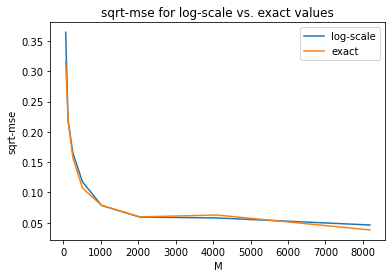

In [8]:
# plot sqrt-mse for log-scale vs. exact
def plot_log_scale_vs_exact(df):
    M_values = df.loc[df['log-scale'] == True][['M']].values
    sqrt_mse_log_scale = df.loc[df['log-scale'] == True][['sqrt-mse']].values
    sqrt_mse_exact = df.loc[df['log-scale'] == False][['sqrt-mse']].values
    _ = plt.plot(M_values, sqrt_mse_log_scale, label='log-scale')
    _ = plt.plot(M_values, sqrt_mse_exact, label='exact')
    plt.title('sqrt-mse for log-scale vs. exact values')
    plt.xlabel('M')
    plt.ylabel('sqrt-mse')
    _ = plt.legend()

plot_log_scale_vs_exact(exp_1_df)
exp_1_df